In [1]:
import os
import sys
import math
import logging
from pathlib import Path

import numpy as np
import scipy as sp

%load_ext autoreload
%autoreload 2

import daft
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
from bhm_at_scale.plot import PlotStore, plot_densities
from bhm_at_scale.utils import make_intervals
from bhm_at_scale.model import Features

## Quick draw of our model

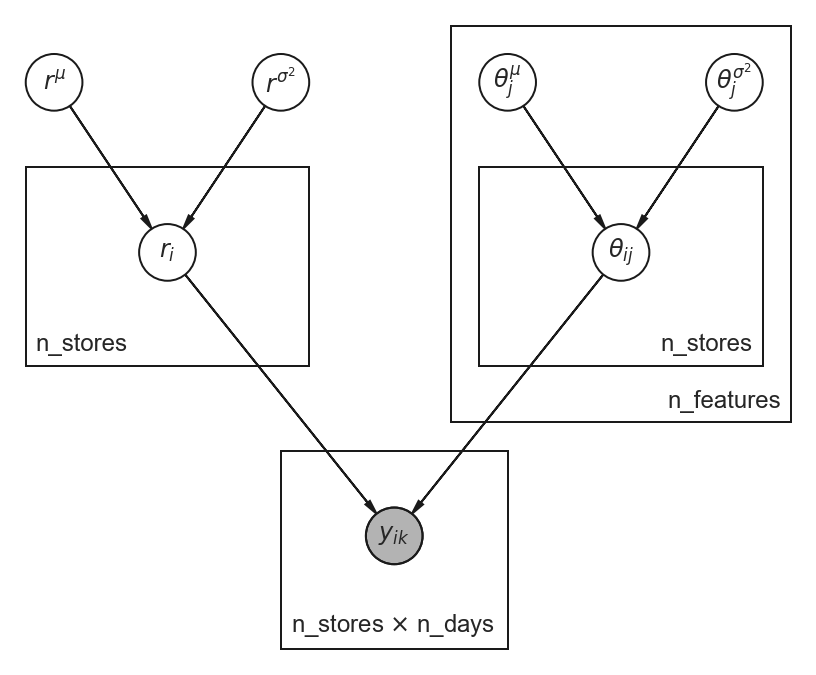

In [3]:
pgm = daft.PGM()
pgm.add_node("disp_param_mu", r"$r^\mu$", 0, 7)
pgm.add_node("disp_param_sigma", r"$r^{\sigma^2}$", 2, 7)
pgm.add_node("coef_mus", r"$\theta^\mu_j$", 4, 7)
pgm.add_node("coef_sigmas", r"$\theta^{\sigma^2}_j$", 6, 7)
pgm.add_node("disp_params", r"$r_i$", 1, 5.5)
pgm.add_plate([-0.25, 4.5, 2.5, 1.75], label=r"n_stores", position='bottom left')
pgm.add_node("coefs", r"$\theta_{ij}$", 5, 5.5)
pgm.add_plate([3.5, 4, 3, 3.5], label="n_features", position='bottom right')
pgm.add_plate([3.75, 4.5, 2.5, 1.75], label=r"n_stores", position='bottom right')
pgm.add_node("sales", r"$y_{ik}$", 3, 3, observed=True)
pgm.add_plate([2, 2, 2, 1.75], label=r"n_stores $\times$ n_days")

pgm.add_edge("disp_param_mu", "disp_params")
pgm.add_edge("disp_param_sigma", "disp_params")
pgm.add_edge("coef_mus", "coefs")
pgm.add_edge("coef_sigmas", "coefs")
pgm.add_edge("disp_params", "sales")
pgm.add_edge("coefs", "sales")

pgm.render()
pgm.savefig("bhm_model.png", dpi=300)

## Read results from notebook 2

In [4]:
df_stats = pd.read_csv('../data/result/stats.csv')
df_preds = pd.read_csv('../data/result/test_preds.csv')
df = pd.read_csv('../data/result/df.csv')
df_edf = pd.read_csv('../data/preprocessed/edf.csv')

## Plot predictions from test set

In [5]:
plot_store = PlotStore(df_orig=df, df_preds=df_preds)

In [6]:
store_id = np.random.randint(df_preds['StoreId'].min(), df_preds['StoreId'].max())
print(store_id)

1095


/Users/fwilhelm/Sources/bhm-at-scale/src/bhm_at_scale/plot.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  g1.set_xticklabels(g1.get_xticklabels(), rotation=90)


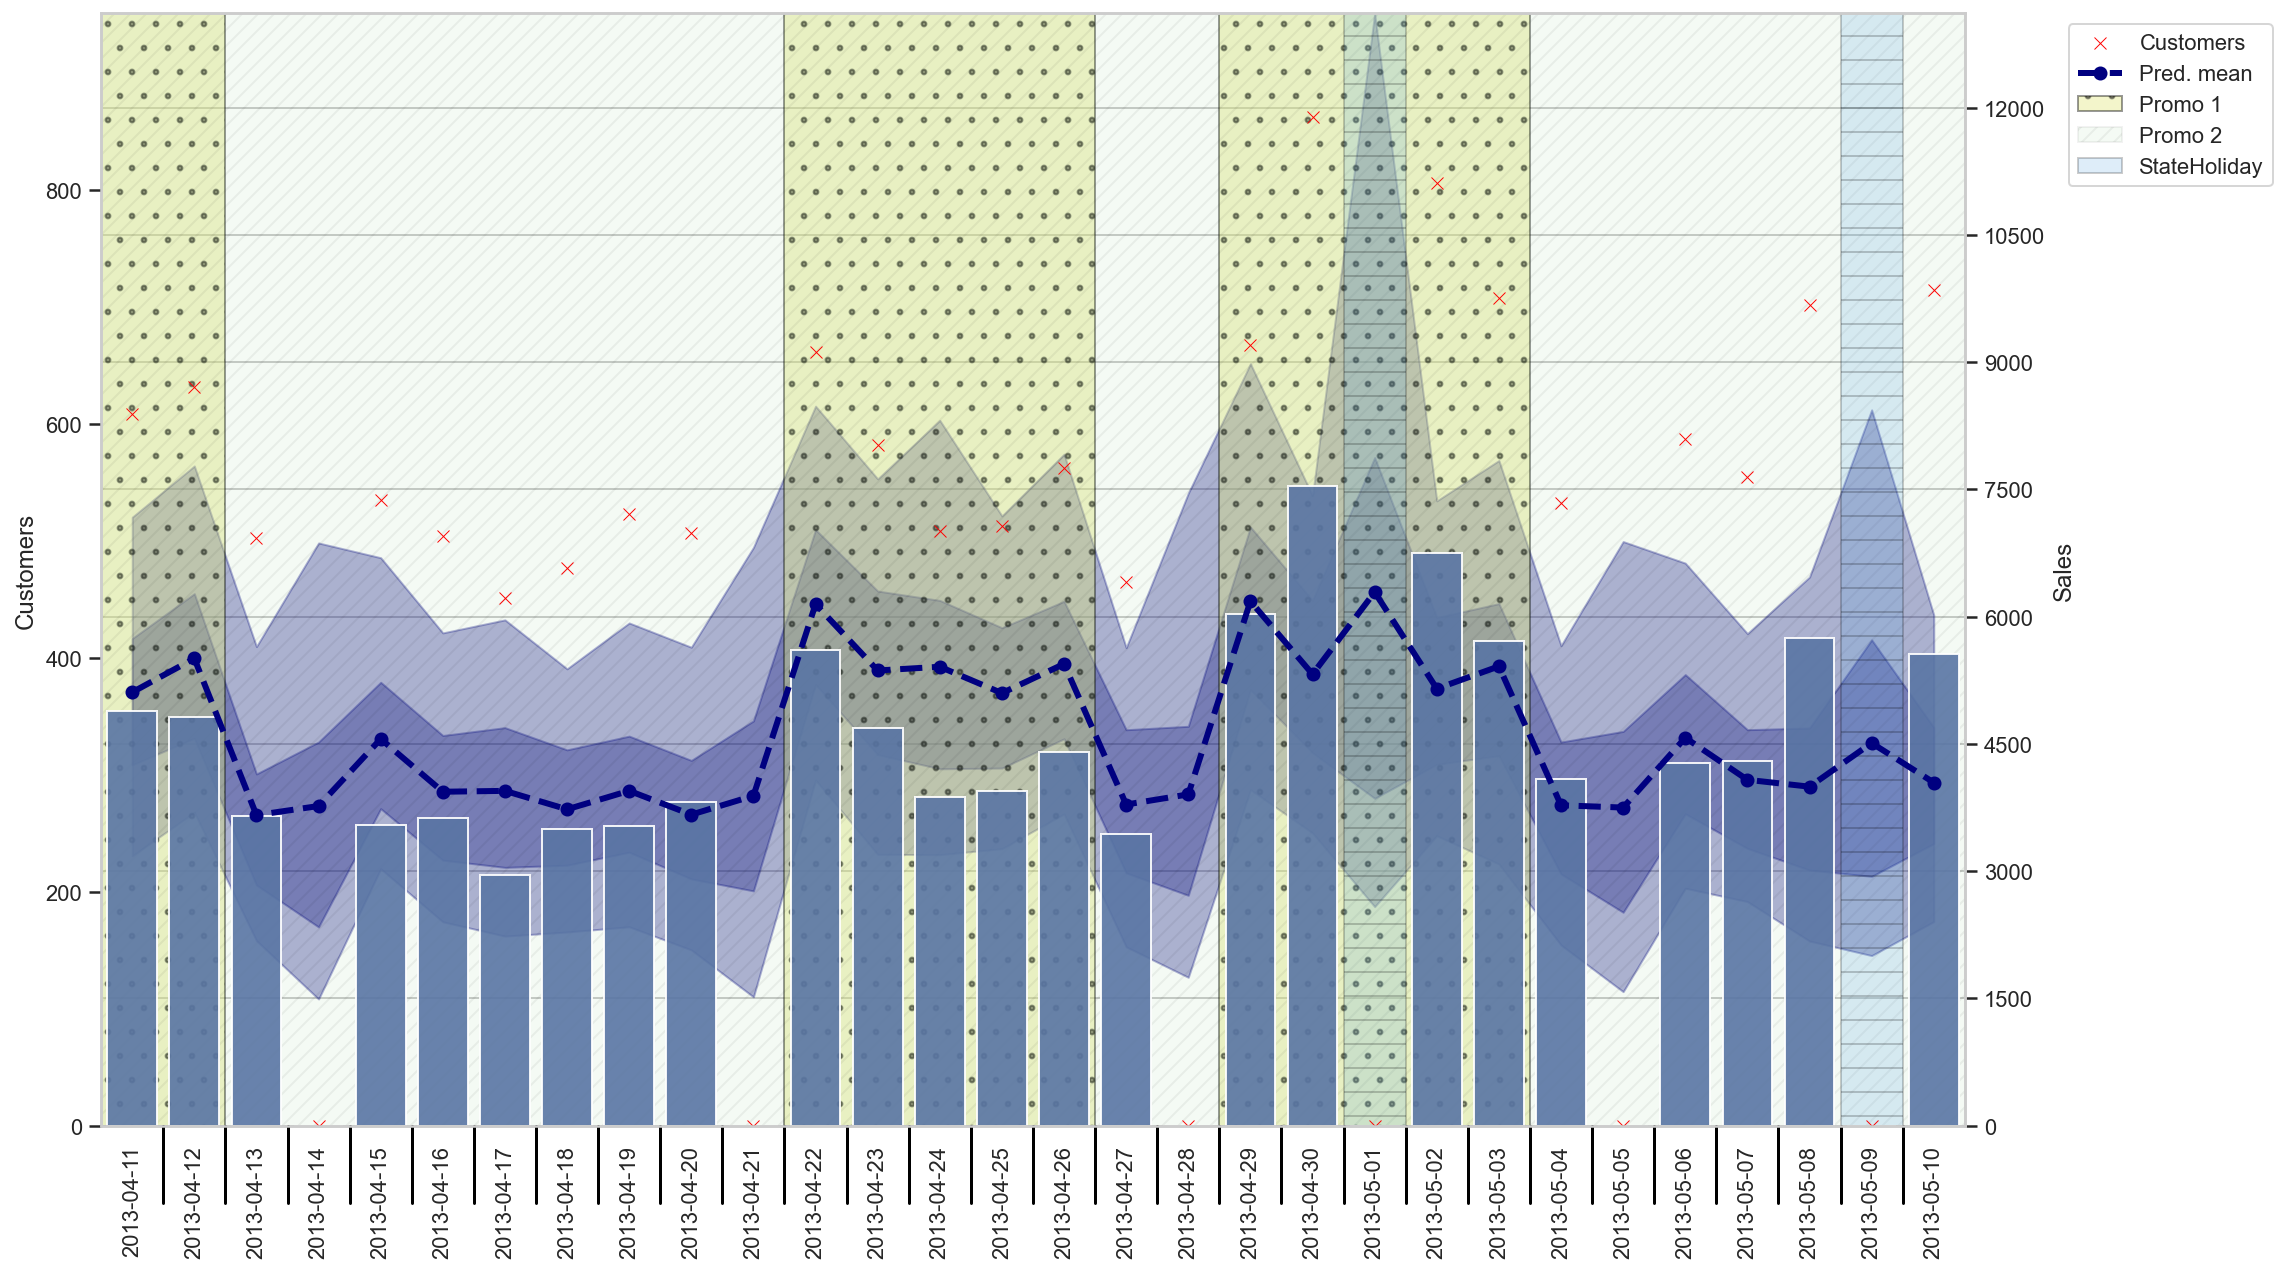

In [7]:
selector = slice(100, 130)
plot_store(store_id, selector);

## Visualize the global weekday effects

In [8]:
coef_mus = pd.read_csv('../data/result/coef_mus.csv')
coef_mus = coef_mus.rename(columns = {str(i): c for i, c in enumerate(df_edf.columns[2:-1])})

In [9]:
coef_mus = coef_mus.filter(regex='DayOfWeek.*')

In [10]:
coef_mus = coef_mus.assign(idx=np.arange(len(coef_mus))).melt(id_vars='idx').drop(columns='idx')

In [11]:
weekday_map = {f"DayOfWeek_{a+1}": b for a, b in zip(range(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])}
coef_mus['variable'] = coef_mus['variable'].replace(weekday_map)

In [12]:
coef_mus['value'] = coef_mus['value'].apply(np.exp)

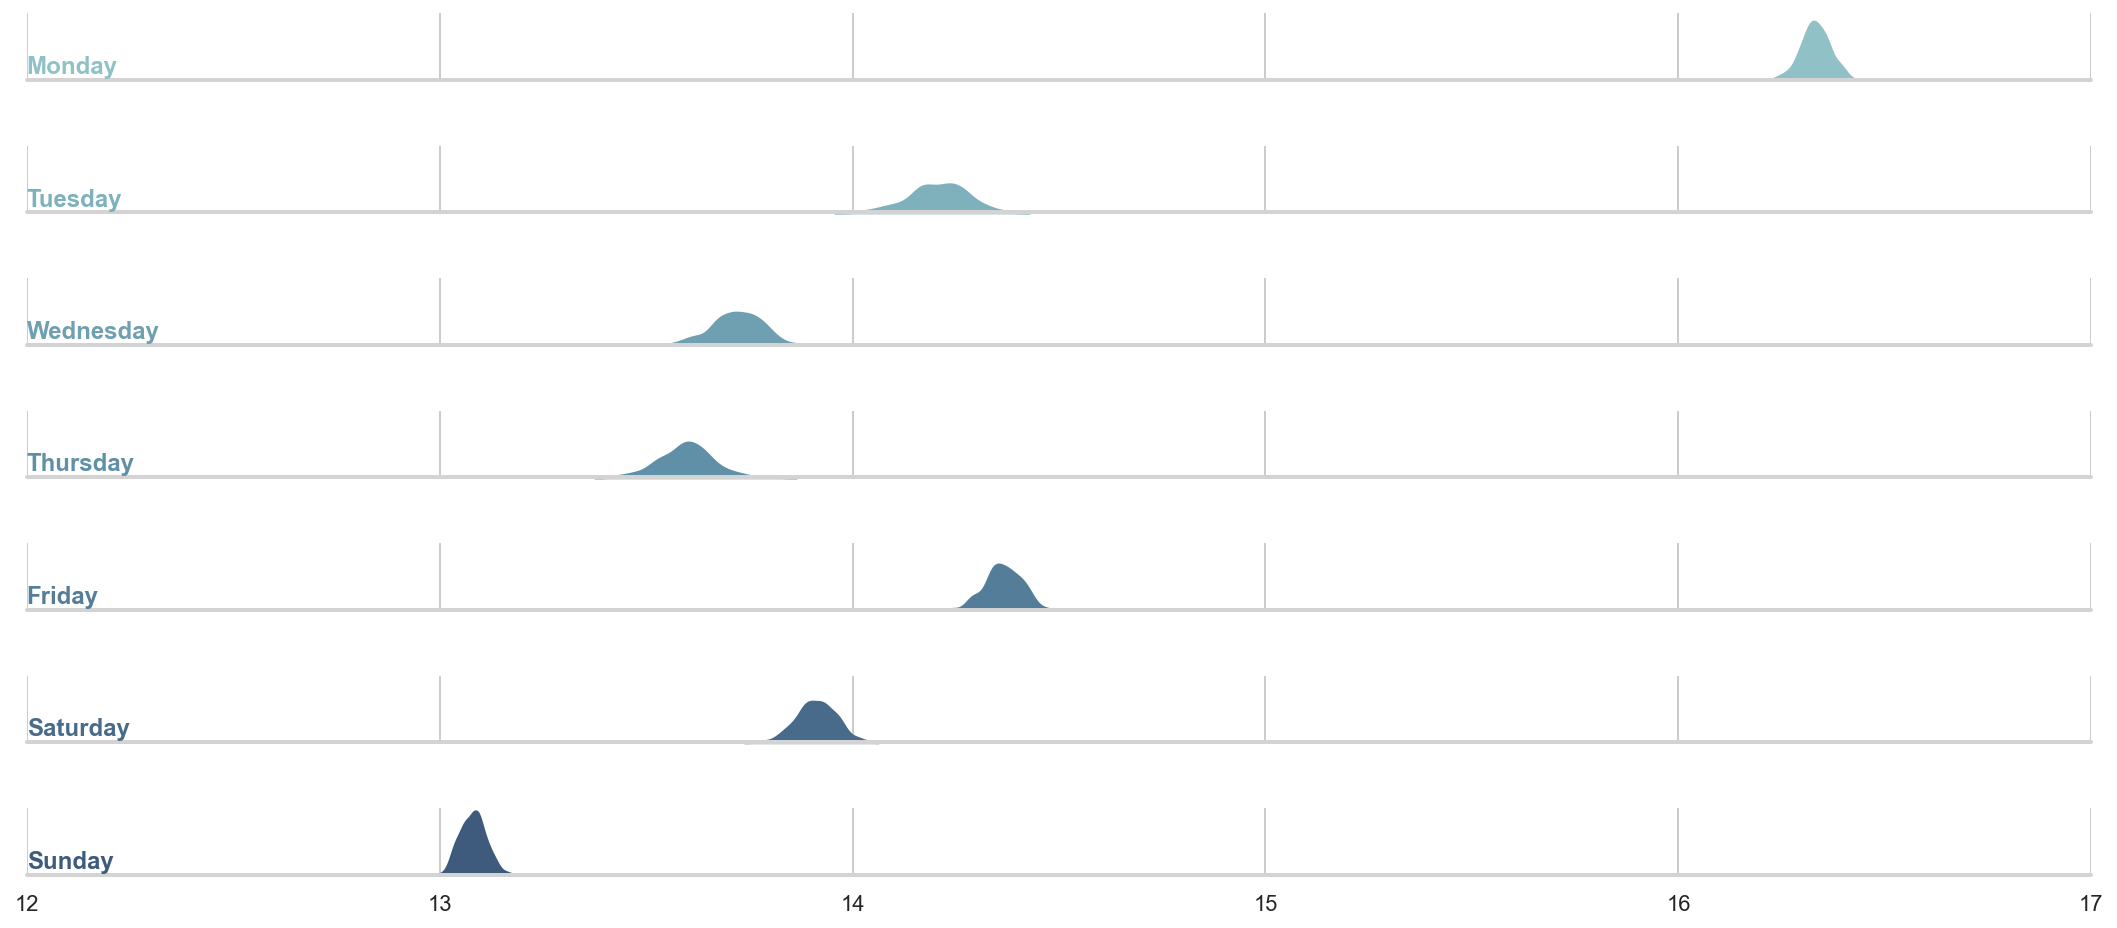

In [13]:
plot_densities(coef_mus, xlim=(12,17))

## Compare with mean effects of the individual stores

In [14]:
mean_weekdays = df_stats.query("site == 'coefs' and metric == 'mean'")
mean_weekdays = mean_weekdays.filter(regex='DayOfWeek.*').assign(idx=np.arange(len(mean_weekdays))).melt(id_vars='idx').drop(columns='idx')

In [15]:
mean_weekdays['variable'] = mean_weekdays['variable'].replace(weekday_map)

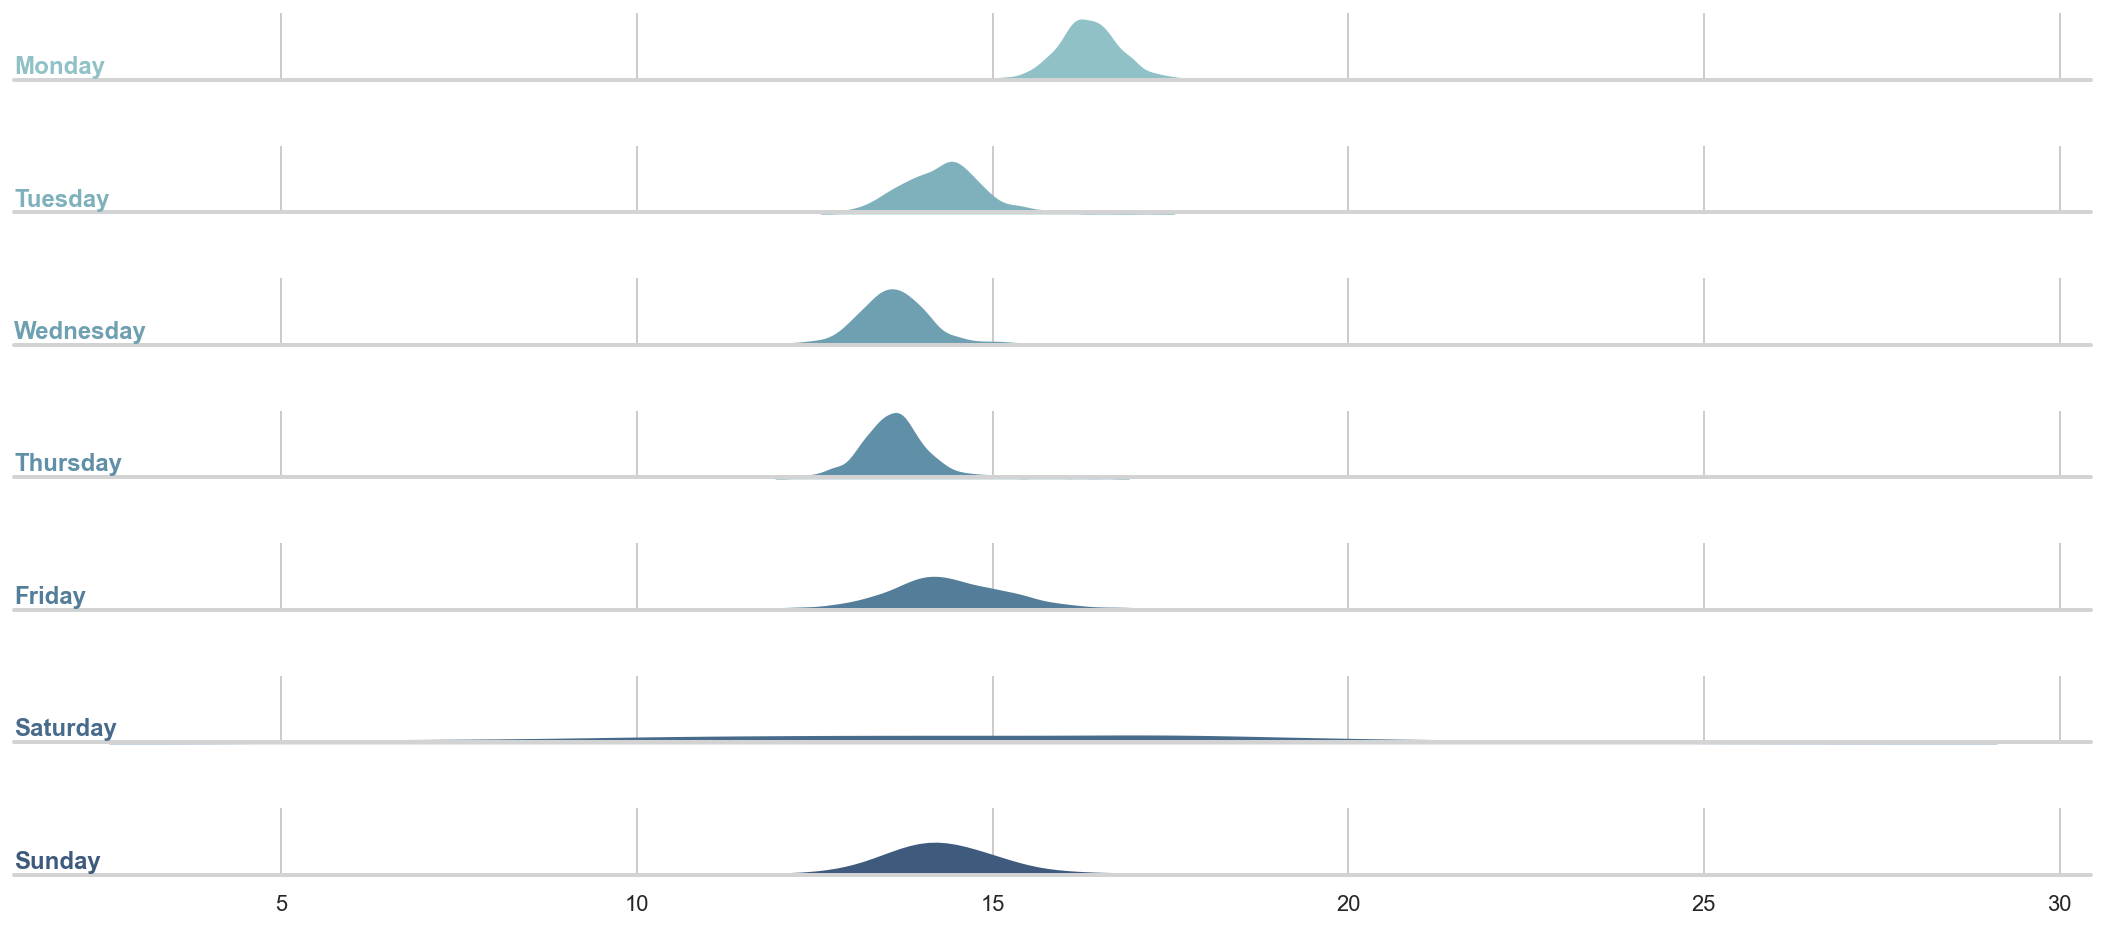

In [16]:
plot_densities(mean_weekdays)

## Visualize the mean promotion effect of the individual stores

/Users/fwilhelm/.miniconda3/envs/bhm-at-scale/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


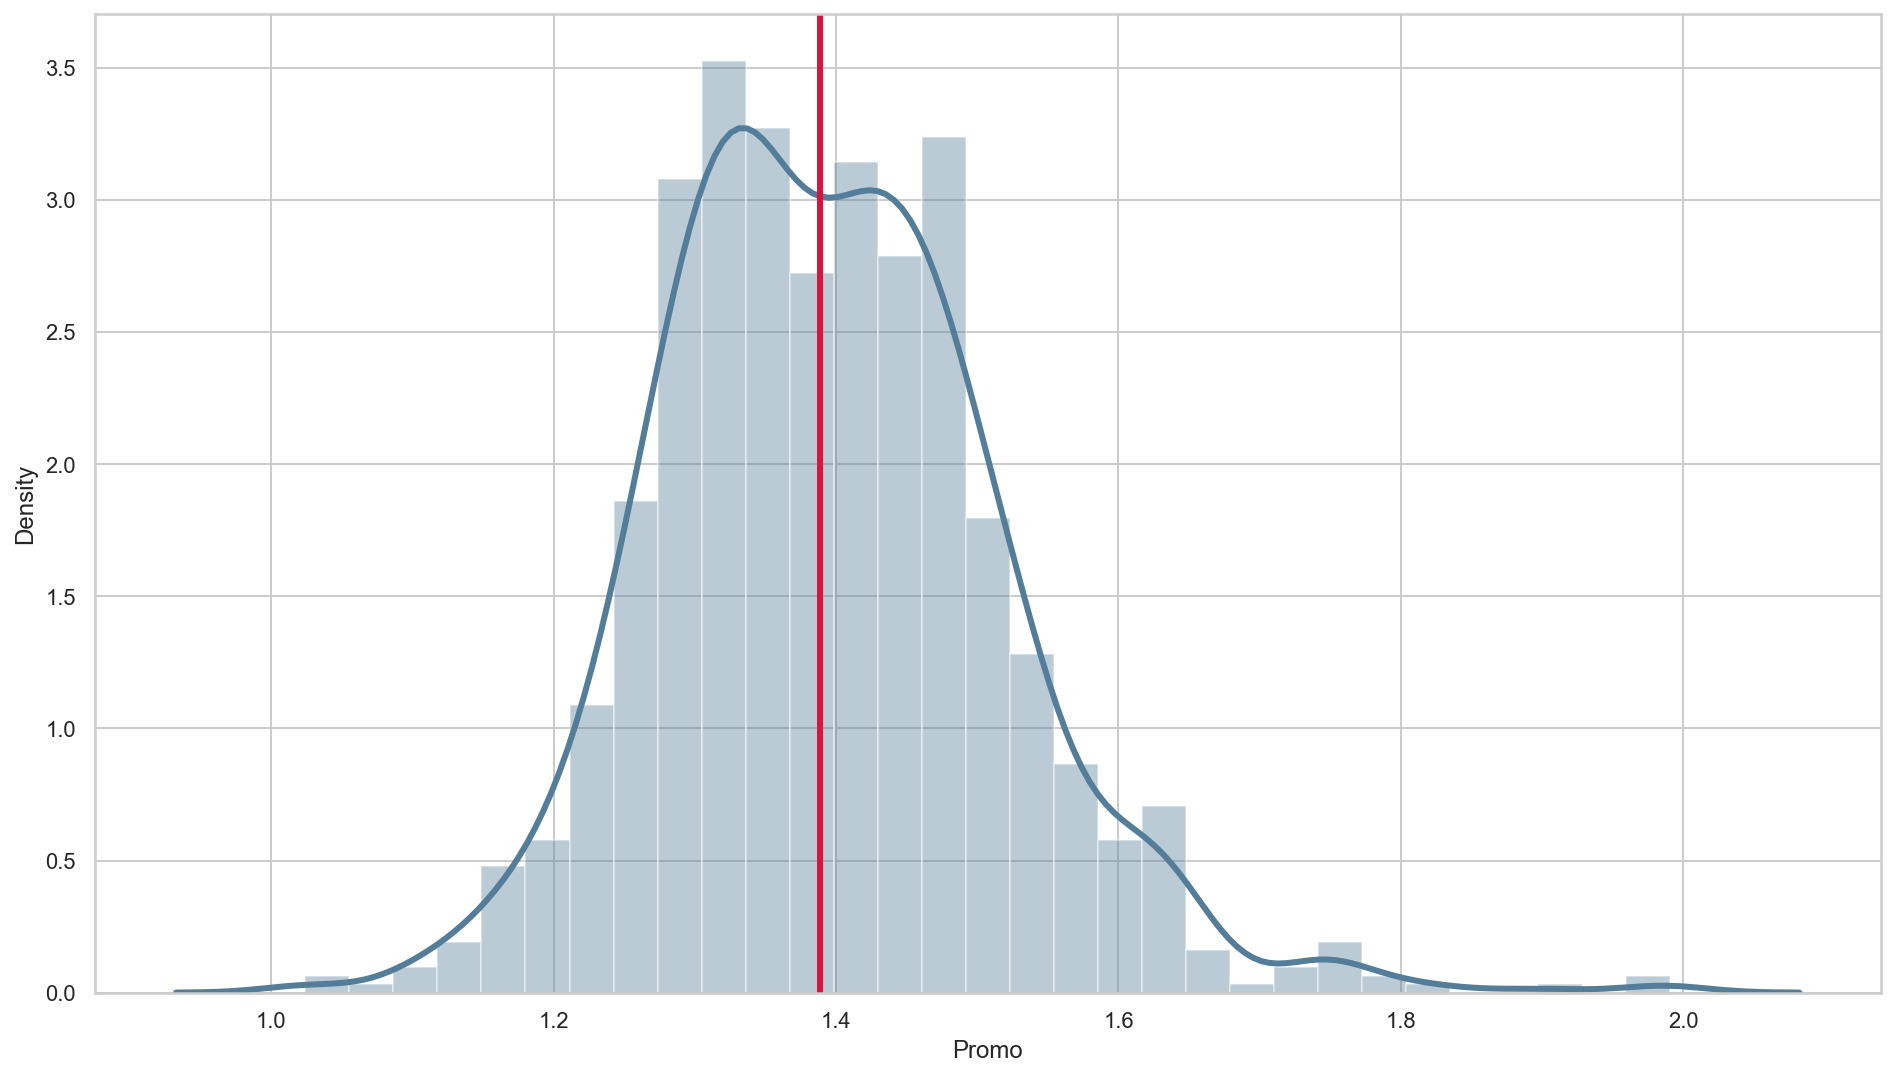

In [17]:
mean_promos = df_stats.query("site == 'coefs' and metric == 'mean'")["Promo"]
sns.distplot(mean_promos, kde_kws=dict(lw=3.), color=sns.cubehelix_palette(10, rot=-.25, light=.7)[4])
plt.axvline(np.median(mean_promos), lw=3, color='crimson');